In [4]:
# Time Series Analysis: Sample Superstore Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical and Time Series Libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [5]:
# Load and prepare the dataset
df = pd.read_csv('Sample_ Superstore.csv')
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
df.head()

Dataset Shape: (9994, 19)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Row ID        9994 non-null   int64  
 1   Order ID      9994 non-null   object 
 2   Order Date    9994 non-null   object 
 3   Ship Date     9994 non-null   object 
 4   Ship Mode     9994 non-null   object 
 5   Customer ID   9994 non-null   object 
 6   Segment       9994 non-null   object 
 7   Country       9994 non-null   object 
 8   City          9994 non-null   object 
 9   State         9994 non-null   object 
 10  Region        9994 non-null   object 
 11  Product ID    9994 non-null   object 
 12  Category      9994 non-null   object 
 13  Sub-Category  9994 non-null   object 
 14  Product Name  9994 non-null   object 
 15  Sales         9994 non-null   float64
 16  Quantity      9994 non-null   int64  
 17  Discount      9994 non-null   

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11-08-2016,11-11-2016,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11-08-2016,11-11-2016,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,06-12-2016,6/16/2016,Second Class,DV-13045,Corporate,United States,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10-11-2015,10/18/2015,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10-11-2015,10/18/2015,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
# Data Preprocessing for Time Series Analysis
print("Columns in dataset:")
print(df.columns.tolist())

# Convert date columns to datetime with mixed format handling
df['Order Date'] = pd.to_datetime(df['Order Date'], format='mixed', dayfirst=False)
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='mixed', dayfirst=False)

# Extract time components
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Quarter'] = df['Order Date'].dt.quarter
df['DayOfWeek'] = df['Order Date'].dt.dayofweek
df['WeekOfYear'] = df['Order Date'].dt.isocalendar().week
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

print("Date range:", df['Order Date'].min(), "to", df['Order Date'].max())
print("Added temporal features:")
print(df[['Order Date', 'Year', 'Month', 'Quarter', 'DayOfWeek', 'IsWeekend']].head())

Columns in dataset:
['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Segment', 'Country', 'City', 'State', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']
Date range: 2014-01-03 00:00:00 to 2017-12-30 00:00:00
Added temporal features:
  Order Date  Year  Month  Quarter  DayOfWeek  IsWeekend
0 2016-11-08  2016     11        4          1          0
1 2016-11-08  2016     11        4          1          0
2 2016-06-12  2016      6        2          6          1
3 2015-10-11  2015     10        4          6          1
4 2015-10-11  2015     10        4          6          1


In [29]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Country,City,State,...,Sales,Quantity,Discount,Profit,Year,Month,Quarter,DayOfWeek,WeekOfYear,IsWeekend
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,...,261.9600,2,0.00,41.9136,2016,11,4,1,45,0
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,...,731.9400,3,0.00,219.5820,2016,11,4,1,45,0
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,United States,Los Angeles,California,...,14.6200,2,0.00,6.8714,2016,6,2,6,23,1
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,...,957.5775,5,0.45,-383.0310,2015,10,4,6,41,1
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,...,22.3680,2,0.20,2.5164,2015,10,4,6,41,1


In [7]:
# 1. DAILY SALES TIME SERIES ANALYSIS

# Create daily aggregated data
daily_sales = df.groupby('Order Date').agg({
    'Row ID': 'count',  # Number of orders
    'Sales': ['sum', 'mean'],  # Total and average sales
    'Quantity': 'sum',  # Total quantity
    'Profit': 'sum',  # Total profit
    'Discount': 'mean'  # Average discount
}).reset_index()

# Flatten column names
daily_sales.columns = ['Date', 'Order_Count', 'Total_Sales', 'Avg_Sales', 'Total_Quantity', 'Total_Profit', 'Avg_Discount']

# Set date as index
daily_sales.set_index('Date', inplace=True)

# Fill missing dates with 0 (business closed days)
date_range = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max(), freq='D')
daily_sales = daily_sales.reindex(date_range, fill_value=0)

print("Daily Sales Summary:")
print(daily_sales.head())
print(f"\nTime series spans from {daily_sales.index.min()} to {daily_sales.index.max()}")
print(f"Total days: {len(daily_sales)}")

Daily Sales Summary:
            Order_Count  Total_Sales   Avg_Sales  Total_Quantity  \
2014-01-03            1       16.448   16.448000               2   
2014-01-04            3      288.060   96.020000               8   
2014-01-05            1       19.536   19.536000               3   
2014-01-06            9     4407.100  489.677778              30   
2014-01-07            2       87.158   43.579000              10   

            Total_Profit  Avg_Discount  
2014-01-03        5.5512           0.2  
2014-01-04      -65.9901           0.4  
2014-01-05        4.8840           0.2  
2014-01-06     1358.0524           0.0  
2014-01-07      -71.9621           0.7  

Time series spans from 2014-01-03 00:00:00 to 2017-12-30 00:00:00
Total days: 1458


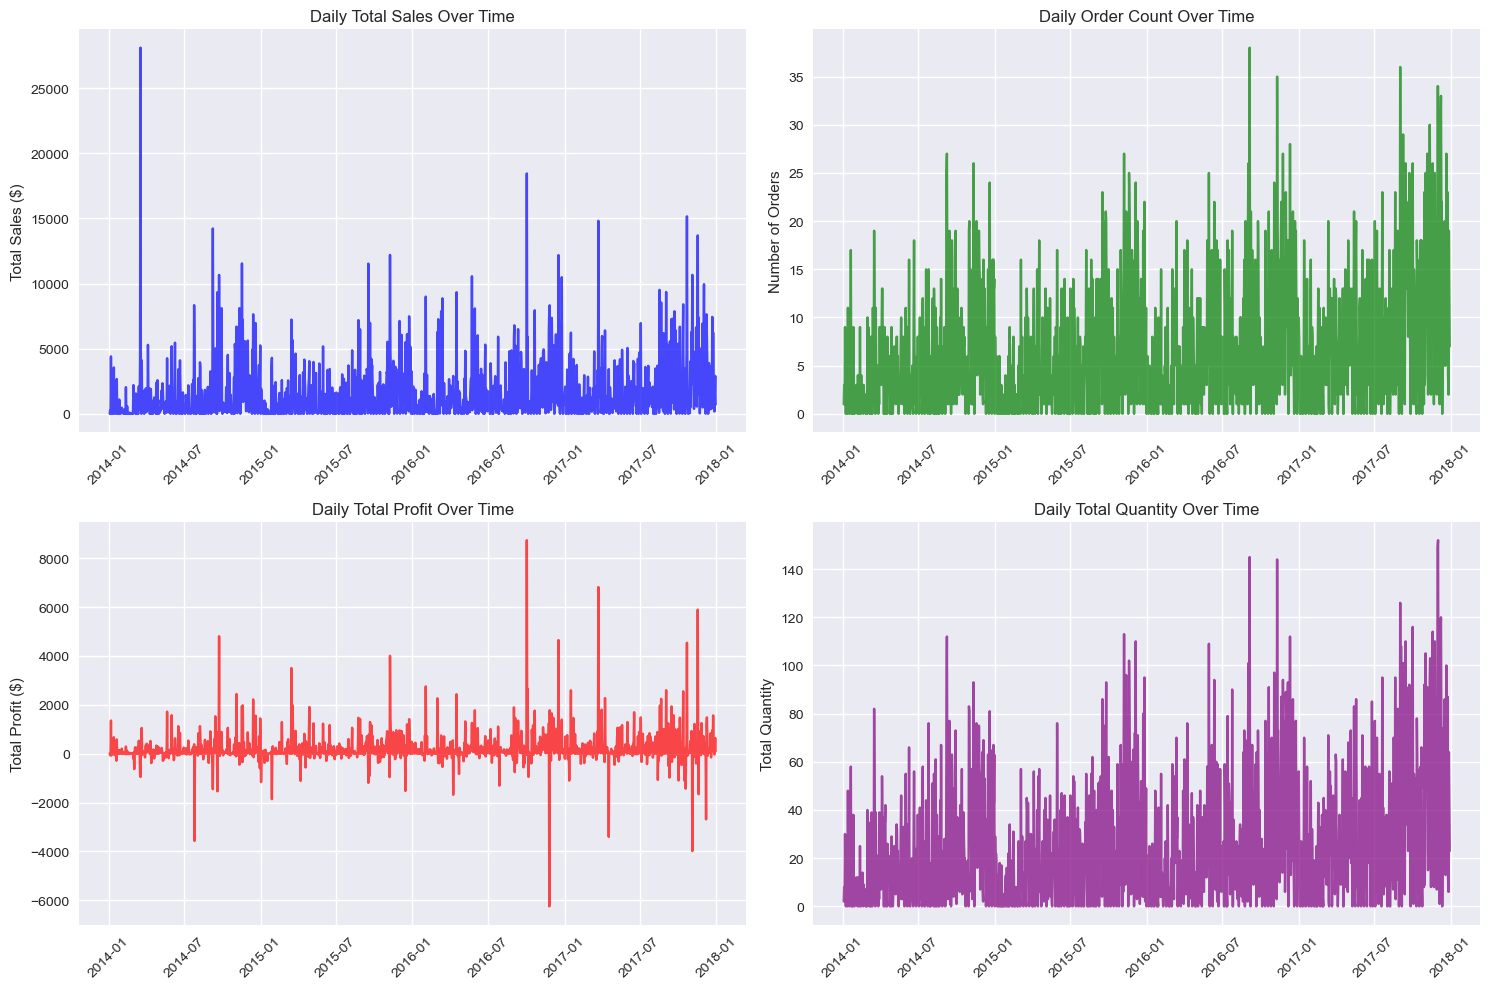

In [8]:
# Visualize the time series data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily sales over time
axes[0,0].plot(daily_sales.index, daily_sales['Total_Sales'], color='blue', alpha=0.7)
axes[0,0].set_title('Daily Total Sales Over Time')
axes[0,0].set_ylabel('Total Sales ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Daily order count over time
axes[0,1].plot(daily_sales.index, daily_sales['Order_Count'], color='green', alpha=0.7)
axes[0,1].set_title('Daily Order Count Over Time')
axes[0,1].set_ylabel('Number of Orders')
axes[0,1].tick_params(axis='x', rotation=45)

# Daily profit over time
axes[1,0].plot(daily_sales.index, daily_sales['Total_Profit'], color='red', alpha=0.7)
axes[1,0].set_title('Daily Total Profit Over Time')
axes[1,0].set_ylabel('Total Profit ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# Daily quantity over time
axes[1,1].plot(daily_sales.index, daily_sales['Total_Quantity'], color='purple', alpha=0.7)
axes[1,1].set_title('Daily Total Quantity Over Time')
axes[1,1].set_ylabel('Total Quantity')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Monthly Sales Data Shape: (48, 6)
            Order_Count  Total_Sales   Avg_Sales  Total_Profit  \
2014-01-31           79    14236.895   81.962139     2450.1907   
2014-02-28           46     4519.892   54.751736      862.3084   
2014-03-31          157    55691.009  242.559597      498.7299   
2014-04-30          135    28295.345  155.780949     3488.8352   
2014-05-31          122    23648.287  208.985220     2738.7096   

            Total_Quantity  Avg_Discount  
2014-01-31             284      0.137386  
2014-02-28             159      0.156548  
2014-03-31             585      0.129014  
2014-04-30             536      0.084941  
2014-05-31             466      0.131158  


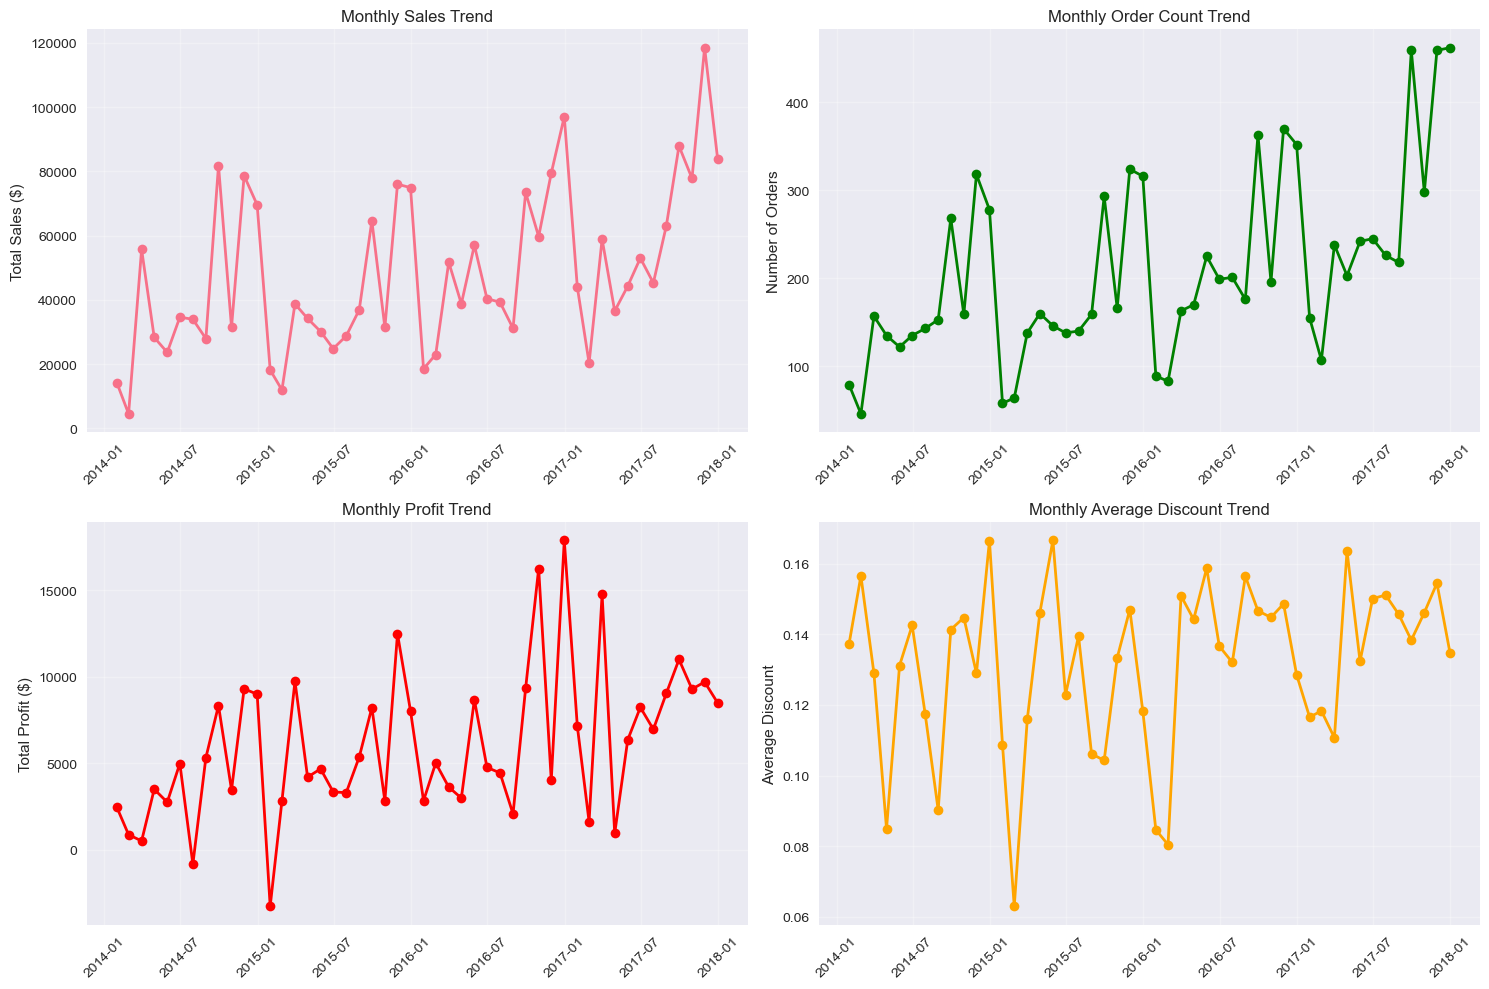

In [9]:
# 2. MONTHLY AGGREGATION FOR BETTER PATTERNS

# Monthly aggregation
monthly_sales = daily_sales.resample('M').agg({
    'Order_Count': 'sum',
    'Total_Sales': 'sum',
    'Avg_Sales': 'mean',
    'Total_Profit': 'sum',
    'Total_Quantity': 'sum',
    'Avg_Discount': 'mean'
})

print("Monthly Sales Data Shape:", monthly_sales.shape)
print(monthly_sales.head())

# Plot monthly trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly sales trend
axes[0,0].plot(monthly_sales.index, monthly_sales['Total_Sales'], marker='o', linewidth=2)
axes[0,0].set_title('Monthly Sales Trend')
axes[0,0].set_ylabel('Total Sales ($)')
axes[0,0].grid(True, alpha=0.3)

# Monthly order count trend
axes[0,1].plot(monthly_sales.index, monthly_sales['Order_Count'], marker='o', color='green', linewidth=2)
axes[0,1].set_title('Monthly Order Count Trend')
axes[0,1].set_ylabel('Number of Orders')
axes[0,1].grid(True, alpha=0.3)

# Monthly profit trend
axes[1,0].plot(monthly_sales.index, monthly_sales['Total_Profit'], marker='o', color='red', linewidth=2)
axes[1,0].set_title('Monthly Profit Trend')
axes[1,0].set_ylabel('Total Profit ($)')
axes[1,0].grid(True, alpha=0.3)

# Monthly average discount trend
axes[1,1].plot(monthly_sales.index, monthly_sales['Avg_Discount'], marker='o', color='orange', linewidth=2)
axes[1,1].set_title('Monthly Average Discount Trend')
axes[1,1].set_ylabel('Average Discount')
axes[1,1].grid(True, alpha=0.3)

for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

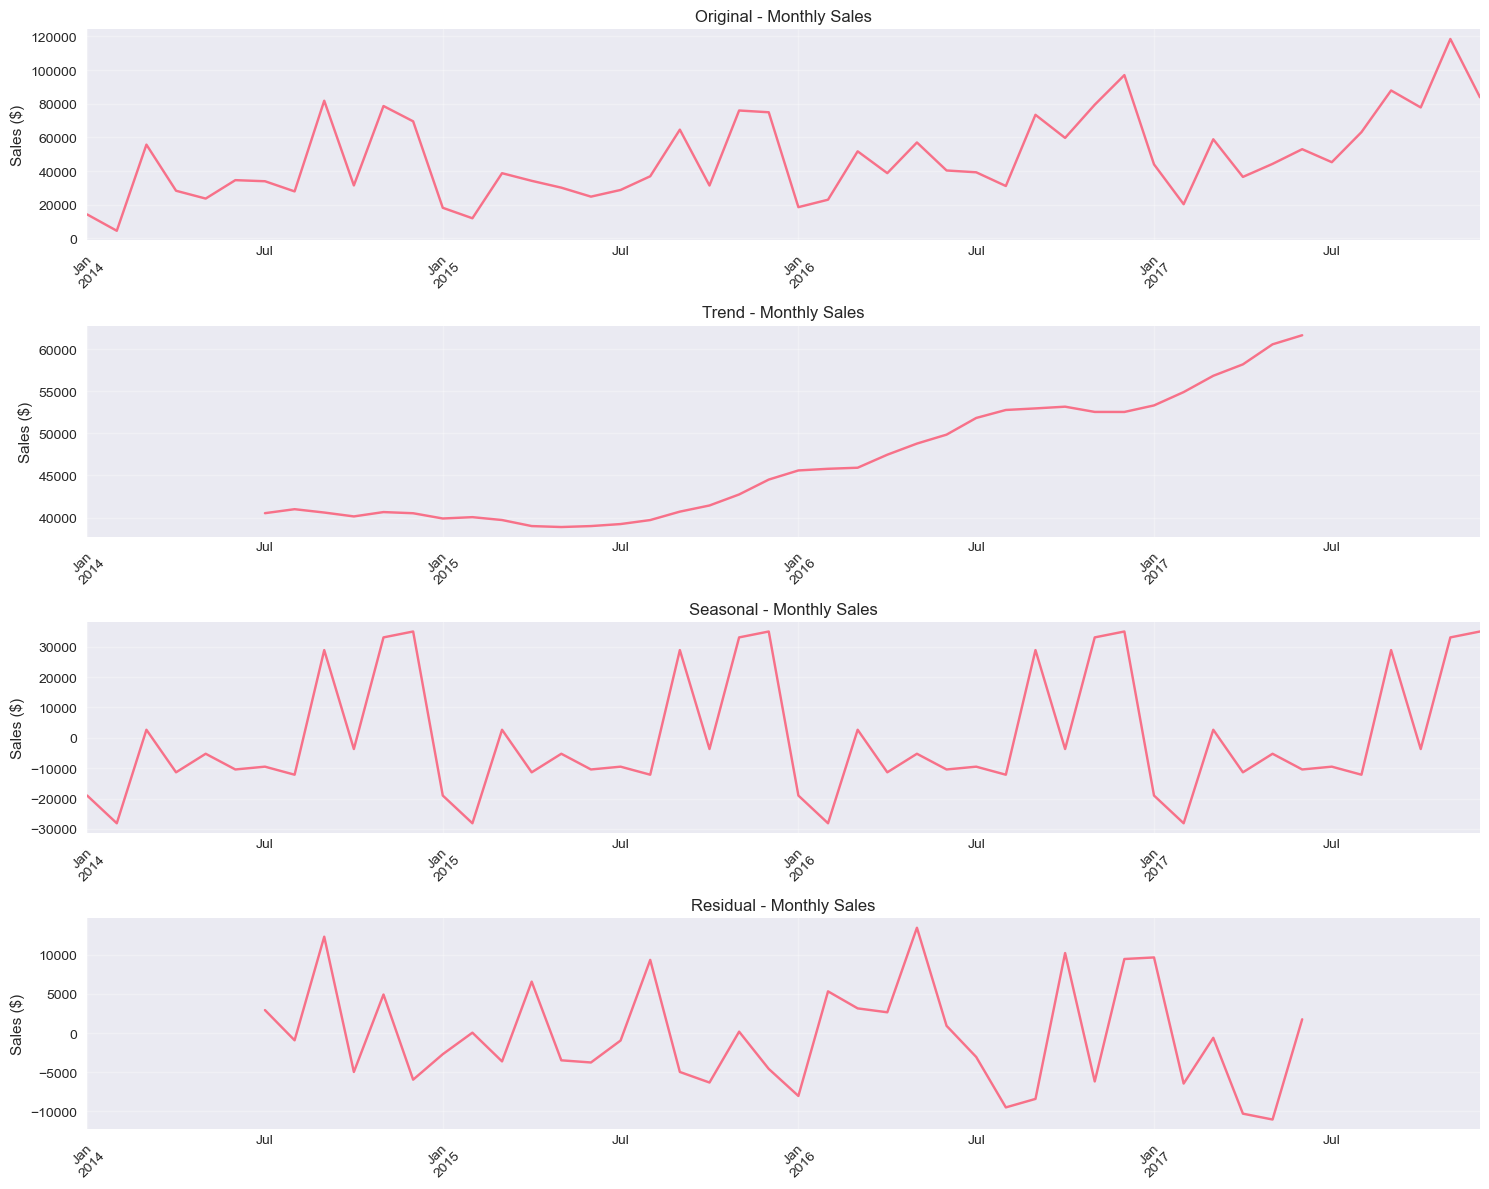


Seasonal Decomposition Insights:
Seasonal Range: $63136.41
Trend Direction: Increasing


In [10]:
# 3. SEASONAL DECOMPOSITION

# Perform seasonal decomposition on monthly sales
decomposition = seasonal_decompose(monthly_sales['Total_Sales'], model='additive', period=12)

# Plot decomposition components
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Original - Monthly Sales')
axes[0].set_ylabel('Sales ($)')

decomposition.trend.plot(ax=axes[1], title='Trend - Monthly Sales')
axes[1].set_ylabel('Sales ($)')

decomposition.seasonal.plot(ax=axes[2], title='Seasonal - Monthly Sales')
axes[2].set_ylabel('Sales ($)')

decomposition.resid.plot(ax=axes[3], title='Residual - Monthly Sales')
axes[3].set_ylabel('Sales ($)')

for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nSeasonal Decomposition Insights:")
print(f"Seasonal Range: ${decomposition.seasonal.max() - decomposition.seasonal.min():.2f}")
print(f"Trend Direction: {'Increasing' if decomposition.trend.dropna().iloc[-1] > decomposition.trend.dropna().iloc[0] else 'Decreasing'}")

In [11]:
# 4. STATIONARITY TESTING

def check_stationarity(timeseries, title):
    """
    Check if a time series is stationary using Augmented Dickey-Fuller test
    """
    print(f'\n=== Stationarity Test for {title} ===')
    
    result = adfuller(timeseries.dropna())
    
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Result: Series is stationary (reject null hypothesis)")
        return True
    else:
        print("Result: Series is not stationary (fail to reject null hypothesis)")
        return False

# Test stationarity for key metrics
is_stationary_sales = check_stationarity(monthly_sales['Total_Sales'], 'Monthly Total Sales')
is_stationary_profit = check_stationarity(monthly_sales['Total_Profit'], 'Monthly Total Profit')


=== Stationarity Test for Monthly Total Sales ===
ADF Statistic: -4.493768
p-value: 0.000202
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601
Result: Series is stationary (reject null hypothesis)

=== Stationarity Test for Monthly Total Profit ===
ADF Statistic: -2.828475
p-value: 0.054320
Critical Values:
	1%: -3.589
	5%: -2.930
	10%: -2.603
Result: Series is not stationary (fail to reject null hypothesis)


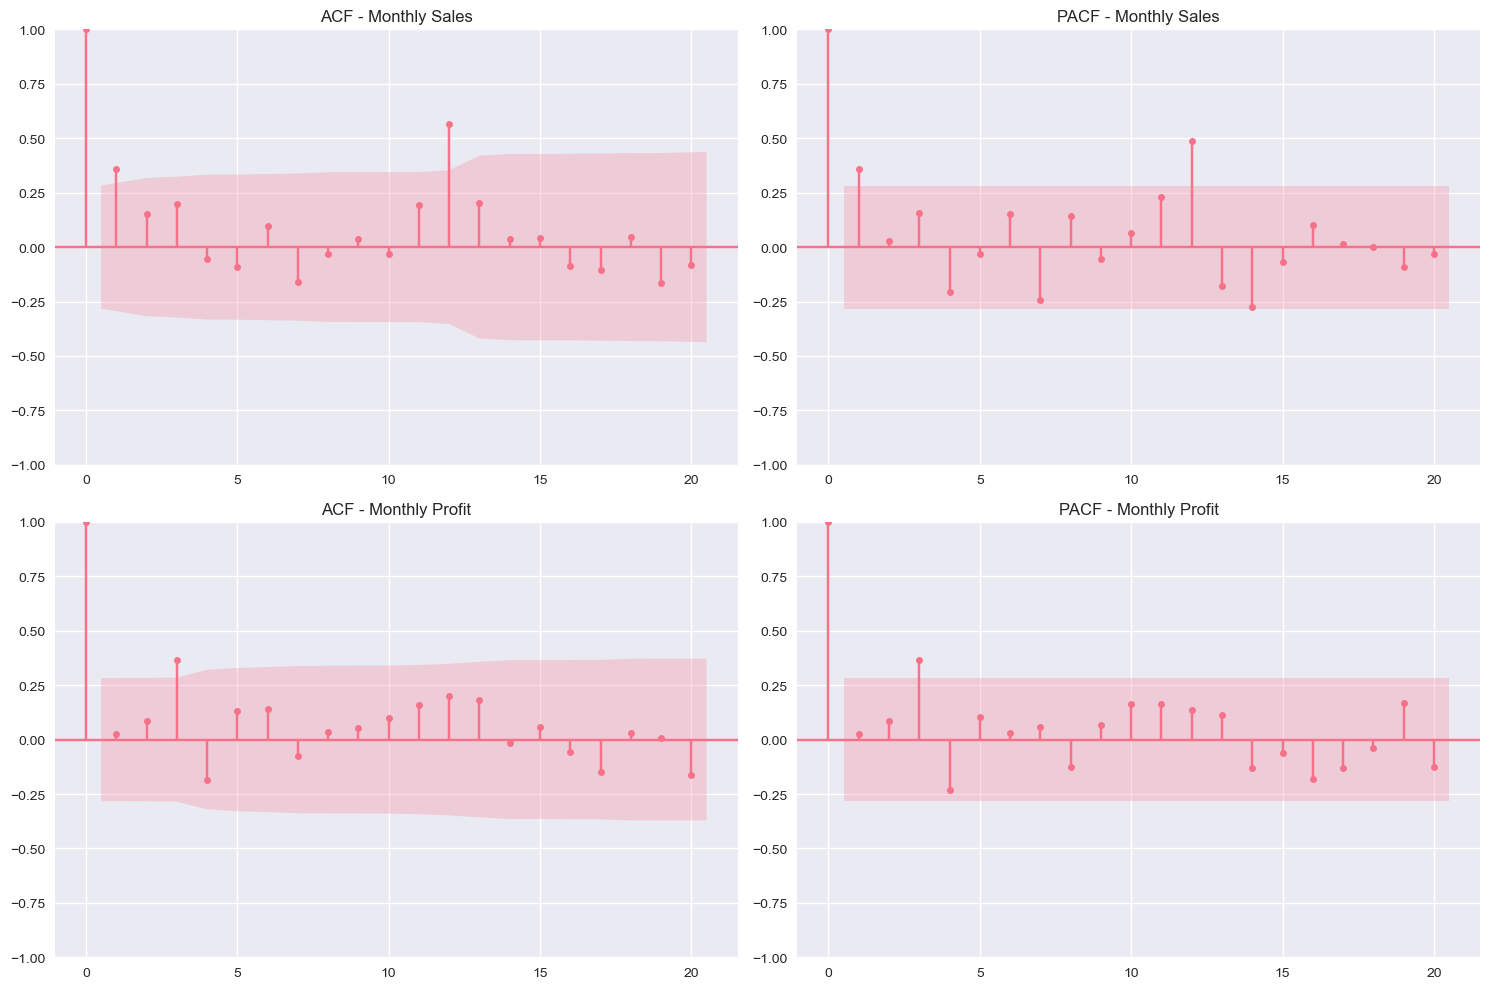

In [12]:
# 5. AUTOCORRELATION ANALYSIS

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ACF and PACF for Sales
plot_acf(monthly_sales['Total_Sales'].dropna(), ax=axes[0,0], lags=20)
axes[0,0].set_title('ACF - Monthly Sales')

plot_pacf(monthly_sales['Total_Sales'].dropna(), ax=axes[0,1], lags=20)
axes[0,1].set_title('PACF - Monthly Sales')

# ACF and PACF for Profit
plot_acf(monthly_sales['Total_Profit'].dropna(), ax=axes[1,0], lags=20)
axes[1,0].set_title('ACF - Monthly Profit')

plot_pacf(monthly_sales['Total_Profit'].dropna(), ax=axes[1,1], lags=20)
axes[1,1].set_title('PACF - Monthly Profit')

plt.tight_layout()
plt.show()

In [13]:
# 6. ARIMA MODEL FOR FORECASTING

def fit_arima_model(data, order=(1,1,1), forecast_steps=6):
    """
    Fit ARIMA model and generate forecasts
    """
    # Split data into train and test
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    # Fit ARIMA model
    model = ARIMA(train_data, order=order)
    fitted_model = model.fit()
    
    # Generate forecasts
    forecast = fitted_model.forecast(steps=len(test_data))
    
    # Future forecasts
    future_forecast = fitted_model.forecast(steps=forecast_steps)
    
    return fitted_model, forecast, future_forecast, train_data, test_data

# Fit ARIMA for Monthly Sales
print("=== ARIMA Model for Monthly Sales ===")
arima_sales, forecast_sales, future_sales, train_sales, test_sales = fit_arima_model(
    monthly_sales['Total_Sales'].dropna(), order=(1,1,1))

print(arima_sales.summary())

=== ARIMA Model for Monthly Sales ===
                               SARIMAX Results                                
Dep. Variable:            Total_Sales   No. Observations:                   38
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -425.517
Date:                Mon, 30 Jun 2025   AIC                            857.035
Time:                        19:47:51   BIC                            861.867
Sample:                    01-31-2014   HQIC                           858.738
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2100      0.310      0.677      0.499      -0.398       0.818
ma.L1         -0.8966      0.145     -6.173      0.000      -1.181      -0.612
sigma2      6.

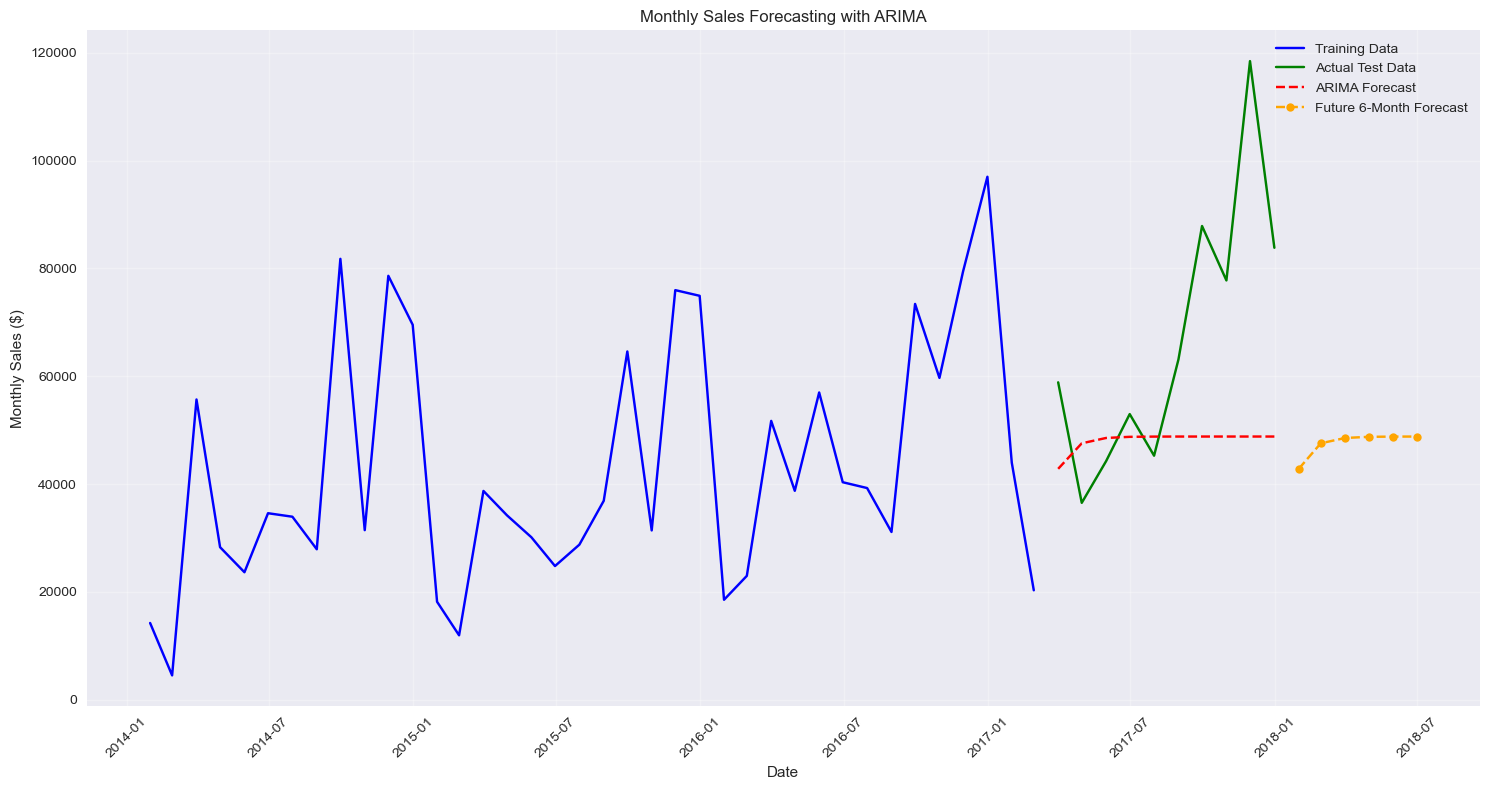


Sales Forecasting Accuracy:
Mean Squared Error: 907010718.95
Root Mean Squared Error: 30116.62
Mean Absolute Error: 22608.93
Mean Absolute Percentage Error: 33.80%


In [14]:
# Visualize ARIMA results
plt.figure(figsize=(15, 8))

# Plot historical data
plt.plot(train_sales.index, train_sales.values, label='Training Data', color='blue')
plt.plot(test_sales.index, test_sales.values, label='Actual Test Data', color='green')

# Plot forecasts
plt.plot(test_sales.index, forecast_sales, label='ARIMA Forecast', color='red', linestyle='--')

# Future forecasts (next 6 months)
future_dates = pd.date_range(start=monthly_sales.index[-1], periods=7, freq='M')[1:]
plt.plot(future_dates, future_sales, label='Future 6-Month Forecast', 
         color='orange', linestyle='--', marker='o', markersize=6)

plt.title('Monthly Sales Forecasting with ARIMA')
plt.xlabel('Date')
plt.ylabel('Monthly Sales ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate accuracy metrics
mse = mean_squared_error(test_sales, forecast_sales)
mae = mean_absolute_error(test_sales, forecast_sales)
rmse = np.sqrt(mse)

print(f"\nSales Forecasting Accuracy:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {(mae/test_sales.mean())*100:.2f}%")

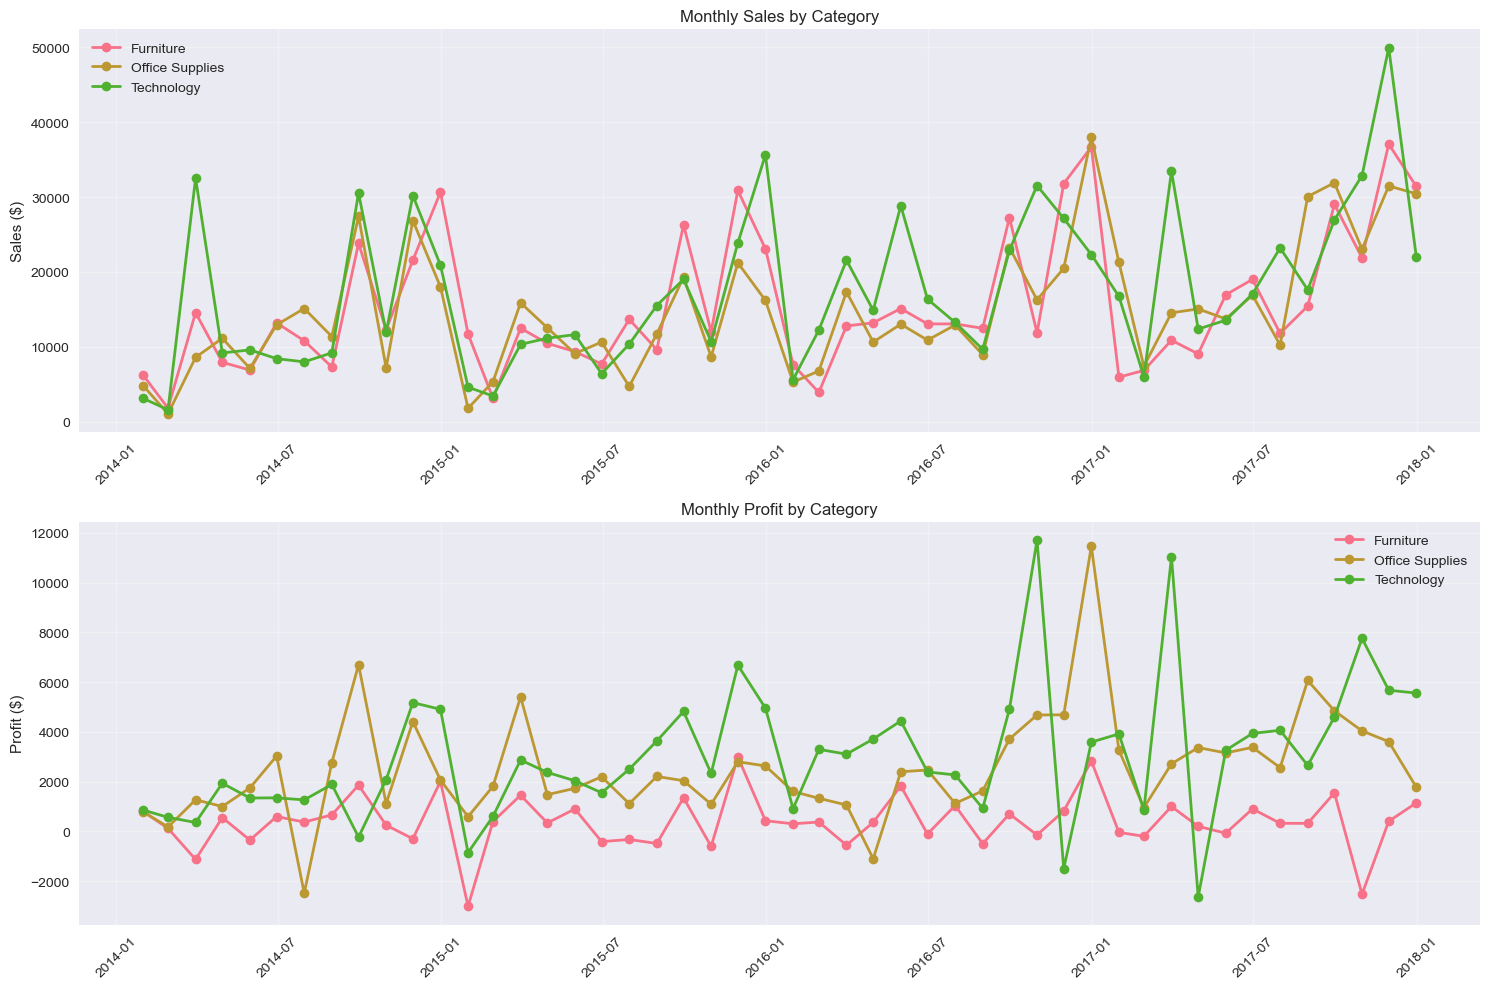

Category performance summary:
                     Sales             Profit        Quantity
                       sum    mean        sum   mean      sum
Category                                                     
Furniture        741999.80  349.83   18451.27   8.70     8028
Office Supplies  719047.03  119.32  122490.80  20.33    22906
Technology       836154.03  452.71  145454.95  78.75     6939


In [15]:
# 7. CATEGORY-WISE TIME SERIES ANALYSIS

# Category analysis over time
category_monthly = df.groupby(['Order Date', 'Category']).agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum'
}).reset_index()

# Pivot for easier analysis
category_sales_pivot = category_monthly.pivot(index='Order Date', columns='Category', values='Sales').fillna(0)
category_profit_pivot = category_monthly.pivot(index='Order Date', columns='Category', values='Profit').fillna(0)

# Resample to monthly data
monthly_category_sales = category_sales_pivot.resample('M').sum()
monthly_category_profit = category_profit_pivot.resample('M').sum()

# Plot category trends
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Sales by category
for category in monthly_category_sales.columns:
    axes[0].plot(monthly_category_sales.index, monthly_category_sales[category], 
                label=category, marker='o', linewidth=2)
axes[0].set_title('Monthly Sales by Category')
axes[0].set_ylabel('Sales ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Profit by category
for category in monthly_category_profit.columns:
    axes[1].plot(monthly_category_profit.index, monthly_category_profit[category], 
                label=category, marker='o', linewidth=2)
axes[1].set_title('Monthly Profit by Category')
axes[1].set_ylabel('Profit ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Category performance summary:")
category_summary = df.groupby('Category').agg({
    'Sales': ['sum', 'mean'],
    'Profit': ['sum', 'mean'],
    'Quantity': 'sum'
}).round(2)
print(category_summary)

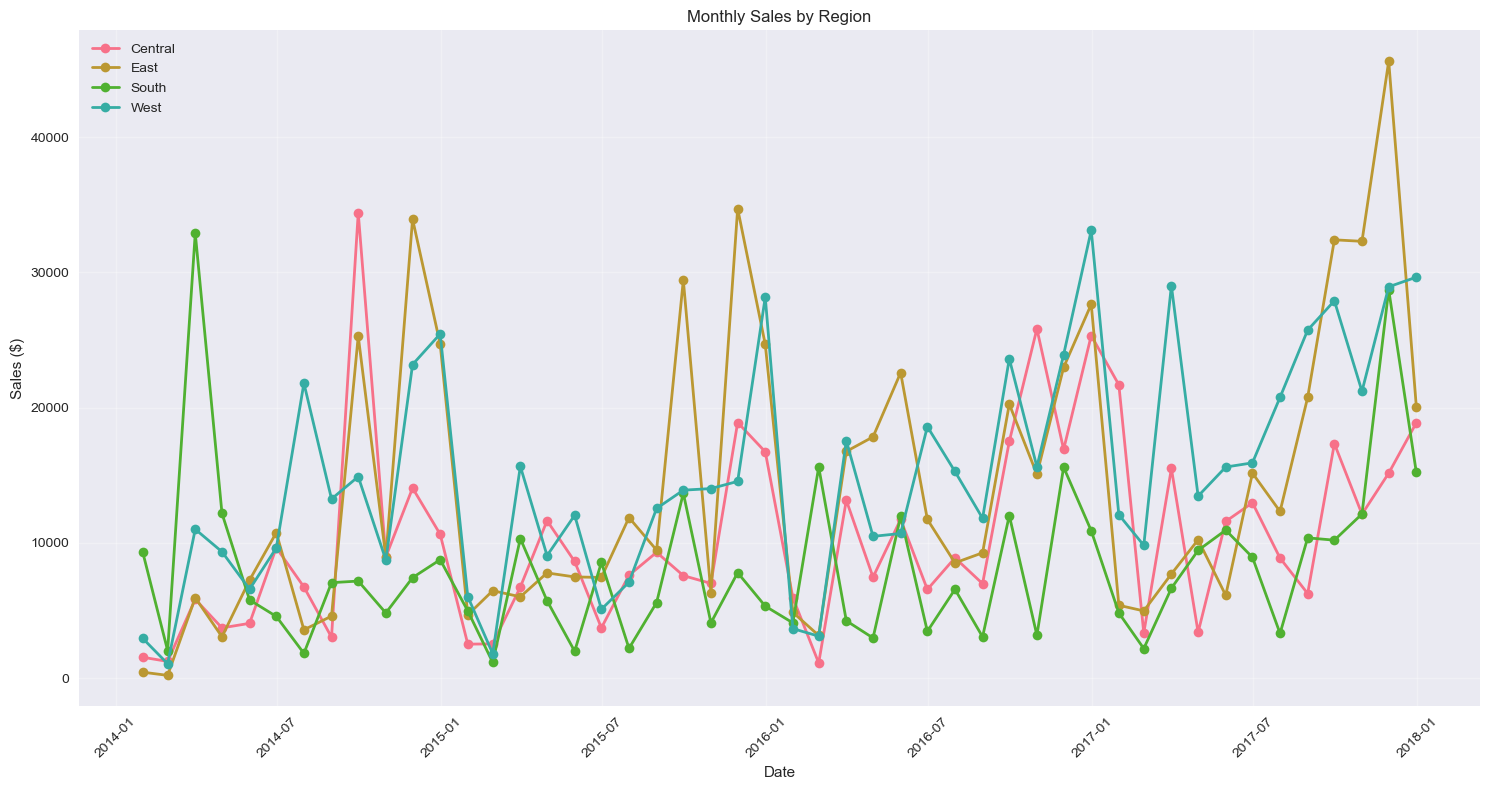

In [16]:
# 8. REGIONAL TIME SERIES PATTERNS

# Regional analysis
regional_monthly = df.groupby(['Order Date', 'Region']).agg({
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index()

regional_sales_pivot = regional_monthly.pivot(index='Order Date', columns='Region', values='Sales').fillna(0)
monthly_regional_sales = regional_sales_pivot.resample('M').sum()

# Plot regional trends
plt.figure(figsize=(15, 8))
for region in monthly_regional_sales.columns:
    plt.plot(monthly_regional_sales.index, monthly_regional_sales[region], 
             label=region, marker='o', linewidth=2)

plt.title('Monthly Sales by Region')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== Exponential Smoothing Model for Monthly Profit ===
Using seasonal model with period=12


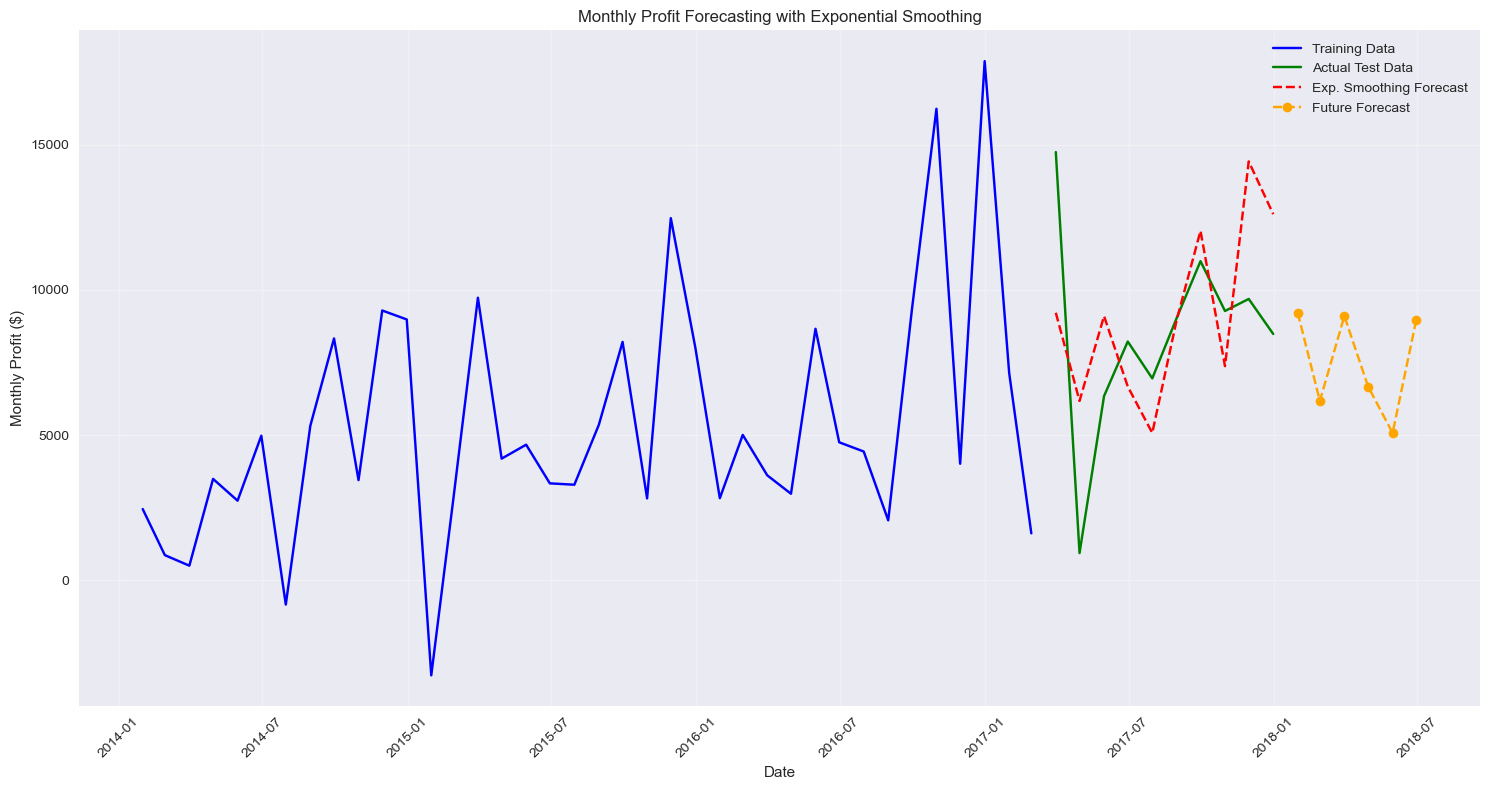


Exponential Smoothing Accuracy:
Mean Squared Error: 11591623.28
Mean Absolute Error: 2884.56


In [17]:
# 9. EXPONENTIAL SMOOTHING MODEL

def fit_exponential_smoothing(data, seasonal_periods=12):
    """
    Fit Exponential Smoothing model
    """
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    try:
        if len(train_data) >= 24:  # Need at least 2 seasonal cycles
            model = ExponentialSmoothing(train_data, 
                                        seasonal='add', 
                                        seasonal_periods=seasonal_periods,
                                        trend='add')
            fitted_model = model.fit()
            print(f"Using seasonal model with period={seasonal_periods}")
        else:
            model = ExponentialSmoothing(train_data, trend='add')
            fitted_model = model.fit()
            print("Using non-seasonal model")
            
    except ValueError as e:
        print(f"Seasonal model failed: {e}")
        model = ExponentialSmoothing(train_data)
        fitted_model = model.fit()
    
    # Generate forecasts
    forecast = fitted_model.forecast(steps=len(test_data))
    future_forecast = fitted_model.forecast(steps=6)
    
    return fitted_model, forecast, future_forecast, train_data, test_data

# Fit Exponential Smoothing for Profit
print("=== Exponential Smoothing Model for Monthly Profit ===")
exp_smooth_profit, forecast_profit, future_profit, train_profit, test_profit = fit_exponential_smoothing(
    monthly_sales['Total_Profit'].dropna())

# Visualize results
plt.figure(figsize=(15, 8))

plt.plot(train_profit.index, train_profit.values, label='Training Data', color='blue')
plt.plot(test_profit.index, test_profit.values, label='Actual Test Data', color='green')
plt.plot(test_profit.index, forecast_profit, label='Exp. Smoothing Forecast', color='red', linestyle='--')

future_dates = pd.date_range(start=monthly_sales.index[-1], periods=7, freq='M')[1:]
plt.plot(future_dates, future_profit, label='Future Forecast', color='orange', linestyle='--', marker='o')

plt.title('Monthly Profit Forecasting with Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Monthly Profit ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

mse_exp = mean_squared_error(test_profit, forecast_profit)
mae_exp = mean_absolute_error(test_profit, forecast_profit)
print(f"\nExponential Smoothing Accuracy:")
print(f"Mean Squared Error: {mse_exp:.2f}")
print(f"Mean Absolute Error: {mae_exp:.2f}")

In [18]:
# 10. BUSINESS INSIGHTS AND SUMMARY

print("="*60)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*60)

# Sales patterns
monthly_avg = monthly_sales['Total_Sales'].mean()
best_month = monthly_sales['Total_Sales'].idxmax()
worst_month = monthly_sales['Total_Sales'].idxmin()

print(f"\n1. SALES PATTERNS:")
print(f"   - Average monthly sales: ${monthly_avg:,.2f}")
print(f"   - Best performing month: {best_month.strftime('%B %Y')} (${monthly_sales.loc[best_month, 'Total_Sales']:,.2f})")
print(f"   - Worst performing month: {worst_month.strftime('%B %Y')} (${monthly_sales.loc[worst_month, 'Total_Sales']:,.2f})")

# Category insights
category_totals = df.groupby('Category')['Sales'].sum().sort_values(ascending=False)
print(f"\n2. CATEGORY PERFORMANCE:")
for i, (category, sales) in enumerate(category_totals.items()):
    print(f"   {i+1}. {category}: ${sales:,.2f}")

# Regional insights
regional_totals = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
print(f"\n3. REGIONAL PERFORMANCE:")
for i, (region, sales) in enumerate(regional_totals.items()):
    print(f"   {i+1}. {region}: ${sales:,.2f}")

# Forecasting summary
print(f"\n4. FORECASTING PREDICTIONS:")
print(f"   - Next 6 months sales forecast: ${future_sales.sum():,.2f}")
print(f"   - Next 6 months profit forecast: ${future_profit.sum():,.2f}")
print(f"   - Average monthly growth predicted: {((future_sales.mean()/monthly_sales['Total_Sales'].mean() - 1) * 100):.1f}%")

# Seasonality insights
seasonal_pattern = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()
peak_month = seasonal_pattern.idxmax()
low_month = seasonal_pattern.idxmin()

print(f"\n5. SEASONAL INSIGHTS:")
print(f"   - Peak sales month (seasonal): {pd.to_datetime(f'2020-{peak_month:02d}-01').strftime('%B')}")
print(f"   - Lowest sales month (seasonal): {pd.to_datetime(f'2020-{low_month:02d}-01').strftime('%B')}")
print(f"   - Seasonal variation: ${seasonal_pattern.max() - seasonal_pattern.min():,.2f}")

print(f"\n6. STRATEGIC RECOMMENDATIONS:")
print(f"   - Focus inventory buildup before {pd.to_datetime(f'2020-{peak_month:02d}-01').strftime('%B')}")
print(f"   - Implement promotional campaigns in {pd.to_datetime(f'2020-{low_month:02d}-01').strftime('%B')}")
print(f"   - Prioritize {category_totals.index[0]} category for maximum revenue")
print(f"   - Expand operations in {regional_totals.index[0]} region")
print(f"   - Monitor forecast accuracy and adjust models quarterly")

BUSINESS INSIGHTS AND RECOMMENDATIONS

1. SALES PATTERNS:
   - Average monthly sales: $47,858.35
   - Best performing month: November 2017 ($118,447.82)
   - Worst performing month: February 2014 ($4,519.89)

2. CATEGORY PERFORMANCE:
   1. Technology: $836,154.03
   2. Furniture: $741,999.80
   3. Office Supplies: $719,047.03

3. REGIONAL PERFORMANCE:
   1. West: $725,457.82
   2. East: $678,781.24
   3. Central: $501,239.89
   4. South: $391,721.91

4. FORECASTING PREDICTIONS:
   - Next 6 months sales forecast: $285,329.53
   - Next 6 months profit forecast: $45,216.37
   - Average monthly growth predicted: -0.6%

5. SEASONAL INSIGHTS:
   - Peak sales month (seasonal): December
   - Lowest sales month (seasonal): February
   - Seasonal variation: $63,136.41

6. STRATEGIC RECOMMENDATIONS:
   - Focus inventory buildup before December
   - Implement promotional campaigns in February
   - Prioritize Technology category for maximum revenue
   - Expand operations in West region
   - Monitor

In [19]:
# 11. CUSTOMER TRAFFIC PREDICTION MODEL

# Create traffic data based on order patterns
traffic_data = df.groupby('Order Date').agg({
    'Row ID': 'count',  # Daily traffic (number of orders)
    'Customer ID': 'nunique',  # Unique customers per day
    'Sales': 'sum',
    'Quantity': 'sum'
}).reset_index()

traffic_data.columns = ['Date', 'Daily_Traffic', 'Unique_Customers', 'Daily_Sales', 'Daily_Quantity']
traffic_data.set_index('Date', inplace=True)

# Fill missing dates and add temporal features
date_range = pd.date_range(start=traffic_data.index.min(), end=traffic_data.index.max(), freq='D')
traffic_data = traffic_data.reindex(date_range, fill_value=0)

# Add temporal features for traffic prediction
traffic_data['DayOfWeek'] = traffic_data.index.dayofweek
traffic_data['Month'] = traffic_data.index.month
traffic_data['Quarter'] = traffic_data.index.quarter
traffic_data['IsWeekend'] = traffic_data['DayOfWeek'].isin([5, 6]).astype(int)
traffic_data['DayOfMonth'] = traffic_data.index.day
traffic_data['WeekOfYear'] = traffic_data.index.isocalendar().week

# Calculate moving averages for trend features
traffic_data['Traffic_MA7'] = traffic_data['Daily_Traffic'].rolling(window=7, min_periods=1).mean()
traffic_data['Traffic_MA30'] = traffic_data['Daily_Traffic'].rolling(window=30, min_periods=1).mean()
traffic_data['Sales_MA7'] = traffic_data['Daily_Sales'].rolling(window=7, min_periods=1).mean()

print("Traffic Data with Features:")
print(traffic_data.head())
print(f"Data shape: {traffic_data.shape}")

Traffic Data with Features:
            Daily_Traffic  Unique_Customers  Daily_Sales  Daily_Quantity  \
2014-01-03              1                 1       16.448               2   
2014-01-04              3                 1      288.060               8   
2014-01-05              1                 1       19.536               3   
2014-01-06              9                 3     4407.100              30   
2014-01-07              2                 1       87.158              10   

            DayOfWeek  Month  Quarter  IsWeekend  DayOfMonth  WeekOfYear  \
2014-01-03          4      1        1          0           3           1   
2014-01-04          5      1        1          1           4           1   
2014-01-05          6      1        1          1           5           1   
2014-01-06          0      1        1          0           6           2   
2014-01-07          1      1        1          0           7           2   

            Traffic_MA7  Traffic_MA30    Sales_MA7  
2014-

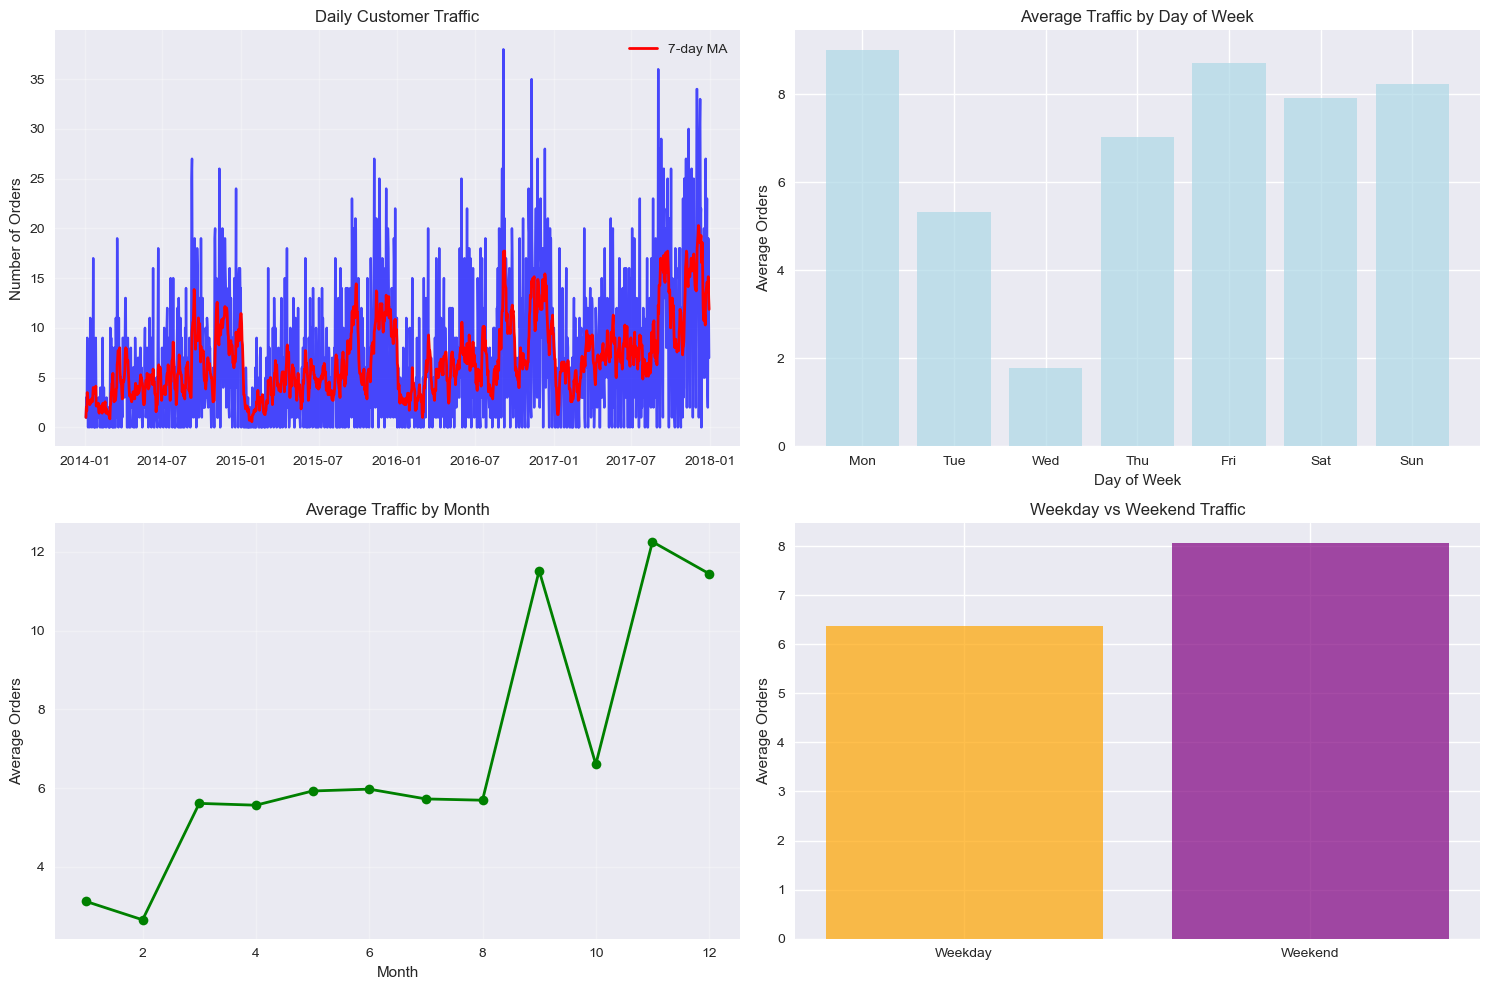

In [20]:
# Visualize traffic patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily traffic over time
axes[0,0].plot(traffic_data.index, traffic_data['Daily_Traffic'], alpha=0.7, color='blue')
axes[0,0].plot(traffic_data.index, traffic_data['Traffic_MA7'], color='red', linewidth=2, label='7-day MA')
axes[0,0].set_title('Daily Customer Traffic')
axes[0,0].set_ylabel('Number of Orders')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Traffic by day of week
dow_traffic = traffic_data.groupby('DayOfWeek')['Daily_Traffic'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0,1].bar(range(7), dow_traffic.values, color='lightblue', alpha=0.7)
axes[0,1].set_title('Average Traffic by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Average Orders')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(days)

# Monthly traffic patterns
monthly_traffic = traffic_data.groupby('Month')['Daily_Traffic'].mean()
axes[1,0].plot(monthly_traffic.index, monthly_traffic.values, marker='o', color='green', linewidth=2)
axes[1,0].set_title('Average Traffic by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Average Orders')
axes[1,0].grid(True, alpha=0.3)

# Weekend vs Weekday traffic
weekend_traffic = traffic_data.groupby('IsWeekend')['Daily_Traffic'].mean()
axes[1,1].bar(['Weekday', 'Weekend'], weekend_traffic.values, color=['orange', 'purple'], alpha=0.7)
axes[1,1].set_title('Weekday vs Weekend Traffic')
axes[1,1].set_ylabel('Average Orders')

plt.tight_layout()
plt.show()

In [21]:
# 12. MACHINE LEARNING MODEL FOR TRAFFIC PREDICTION

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Prepare features for ML model
feature_cols = ['DayOfWeek', 'Month', 'Quarter', 'IsWeekend', 'DayOfMonth', 
                'WeekOfYear', 'Traffic_MA7', 'Traffic_MA30', 'Sales_MA7']

# Remove rows with NaN values
ml_data = traffic_data.dropna()

X = ml_data[feature_cols]
y = ml_data['Daily_Traffic']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression()
}

model_results = {}

for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    model_results[name] = {
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Model': model,
        'Predictions': y_pred
    }
    
    print(f"\n{name} Results:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")

# Select best model
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['R2'])
best_model = model_results[best_model_name]['Model']
print(f"\nBest model: {best_model_name}")


Random Forest Results:
  R² Score: 0.3947
  MAE: 3.82
  RMSE: 5.11

Gradient Boosting Results:
  R² Score: 0.4457
  MAE: 3.64
  RMSE: 4.89

Linear Regression Results:
  R² Score: 0.3166
  MAE: 4.03
  RMSE: 5.43

Best model: Gradient Boosting


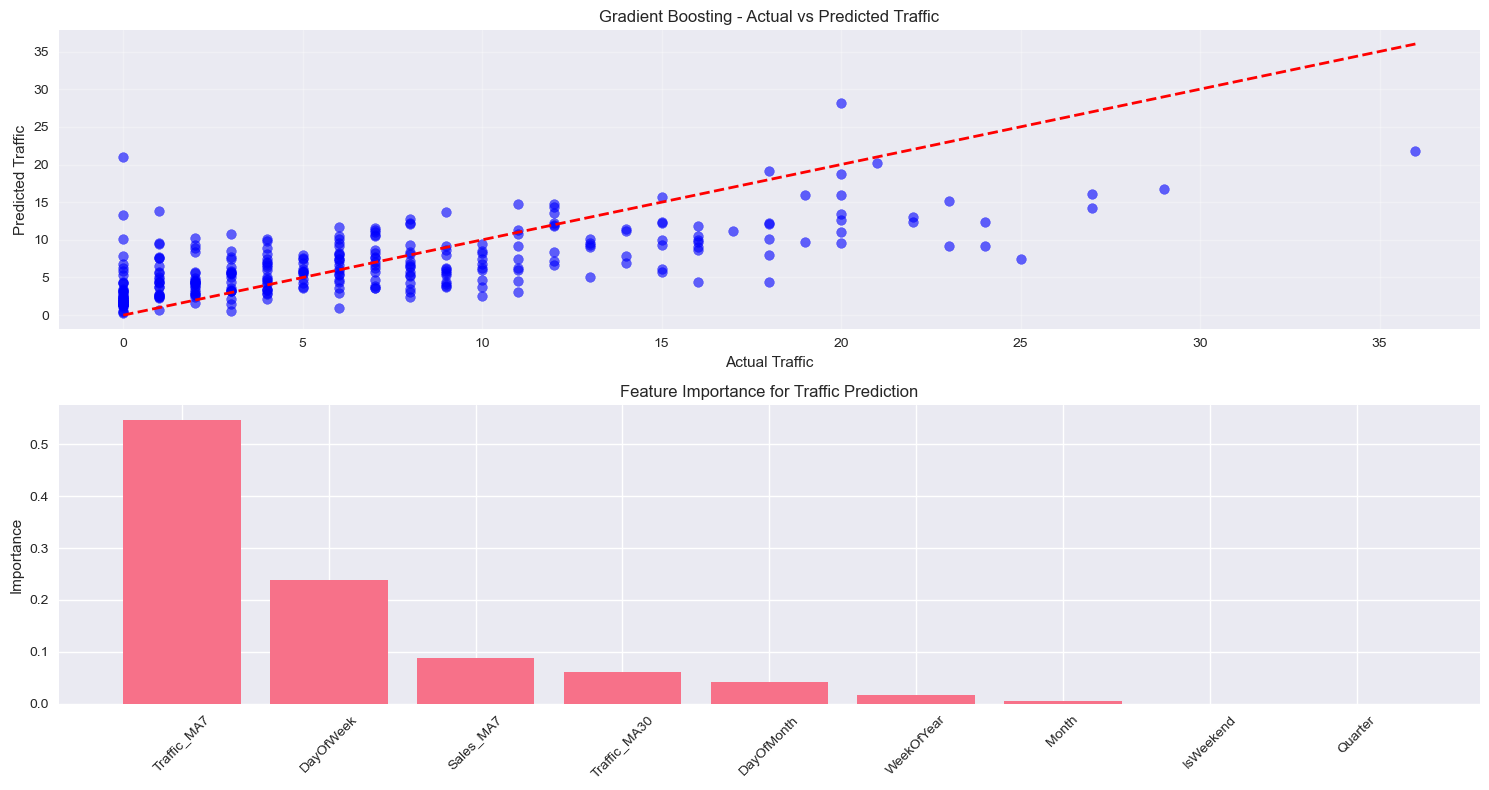

In [22]:
# Visualize traffic prediction results
plt.figure(figsize=(15, 8))

# Plot actual vs predicted for best model
y_pred_best = model_results[best_model_name]['Predictions']

plt.subplot(2, 1, 1)
plt.scatter(y_test, y_pred_best, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Traffic')
plt.ylabel('Predicted Traffic')
plt.title(f'{best_model_name} - Actual vs Predicted Traffic')
plt.grid(True, alpha=0.3)

# Feature importance (for tree-based models)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    plt.subplot(2, 1, 2)
    importances = best_model.feature_importances_
    feature_names = feature_cols
    indices = np.argsort(importances)[::-1]
    
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.title('Feature Importance for Traffic Prediction')
    plt.ylabel('Importance')

plt.tight_layout()
plt.show()

In [23]:
# 13. HOT PRODUCTS PREDICTION MODEL

# Analyze product performance over time
product_performance = df.groupby(['Order Date', 'Product Name']).agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'Profit': 'sum',
    'Row ID': 'count'  # Number of orders
}).reset_index()

product_performance.columns = ['Date', 'Product', 'Sales', 'Quantity', 'Profit', 'Order_Count']

# Calculate product velocity and popularity metrics
product_metrics = df.groupby('Product Name').agg({
    'Sales': ['sum', 'mean', 'count'],
    'Quantity': 'sum',
    'Profit': ['sum', 'mean'],
    'Row ID': 'count',
    'Discount': 'mean'
}).round(2)

product_metrics.columns = ['Total_Sales', 'Avg_Sales', 'Sales_Frequency', 'Total_Quantity', 
                          'Total_Profit', 'Avg_Profit', 'Order_Frequency', 'Avg_Discount']

# Calculate product velocity score
product_metrics['Velocity_Score'] = (
    product_metrics['Sales_Frequency'] * 0.3 +
    product_metrics['Total_Sales'] / product_metrics['Total_Sales'].max() * 0.4 +
    product_metrics['Total_Profit'] / product_metrics['Total_Profit'].max() * 0.3
)

# Categorize products as Hot, Warm, or Cold
product_metrics['Category_Performance'] = pd.cut(
    product_metrics['Velocity_Score'], 
    bins=3, 
    labels=['Cold', 'Warm', 'Hot']
)

print("Product Performance Categories:")
print(product_metrics['Category_Performance'].value_counts())
print("\nTop 10 Hot Products:")
hot_products = product_metrics.sort_values('Velocity_Score', ascending=False).head(10)
print(hot_products[['Total_Sales', 'Total_Profit', 'Velocity_Score', 'Category_Performance']])

Product Performance Categories:
Category_Performance
Cold    1842
Warm       5
Hot        3
Name: count, dtype: int64

Top 10 Hot Products:
                                            Total_Sales  Total_Profit  \
Product Name                                                            
Staple envelope                                 1686.81        751.63   
Easy-staple paper                               2504.19       1096.03   
Staples                                          755.47        292.20   
Avery Non-Stick Binders                          217.32         43.55   
Staples in misc. colors                          478.81        124.05   
KI Adjustable-Height Table                      4552.64       -248.48   
Staple remover                                   263.09         24.07   
Storex Dura Pro Binders                          278.59         50.55   
Staple-based wall hangings                       422.29        121.99   
Situations Contoured Folding Chairs, 4/Set      3641.27  

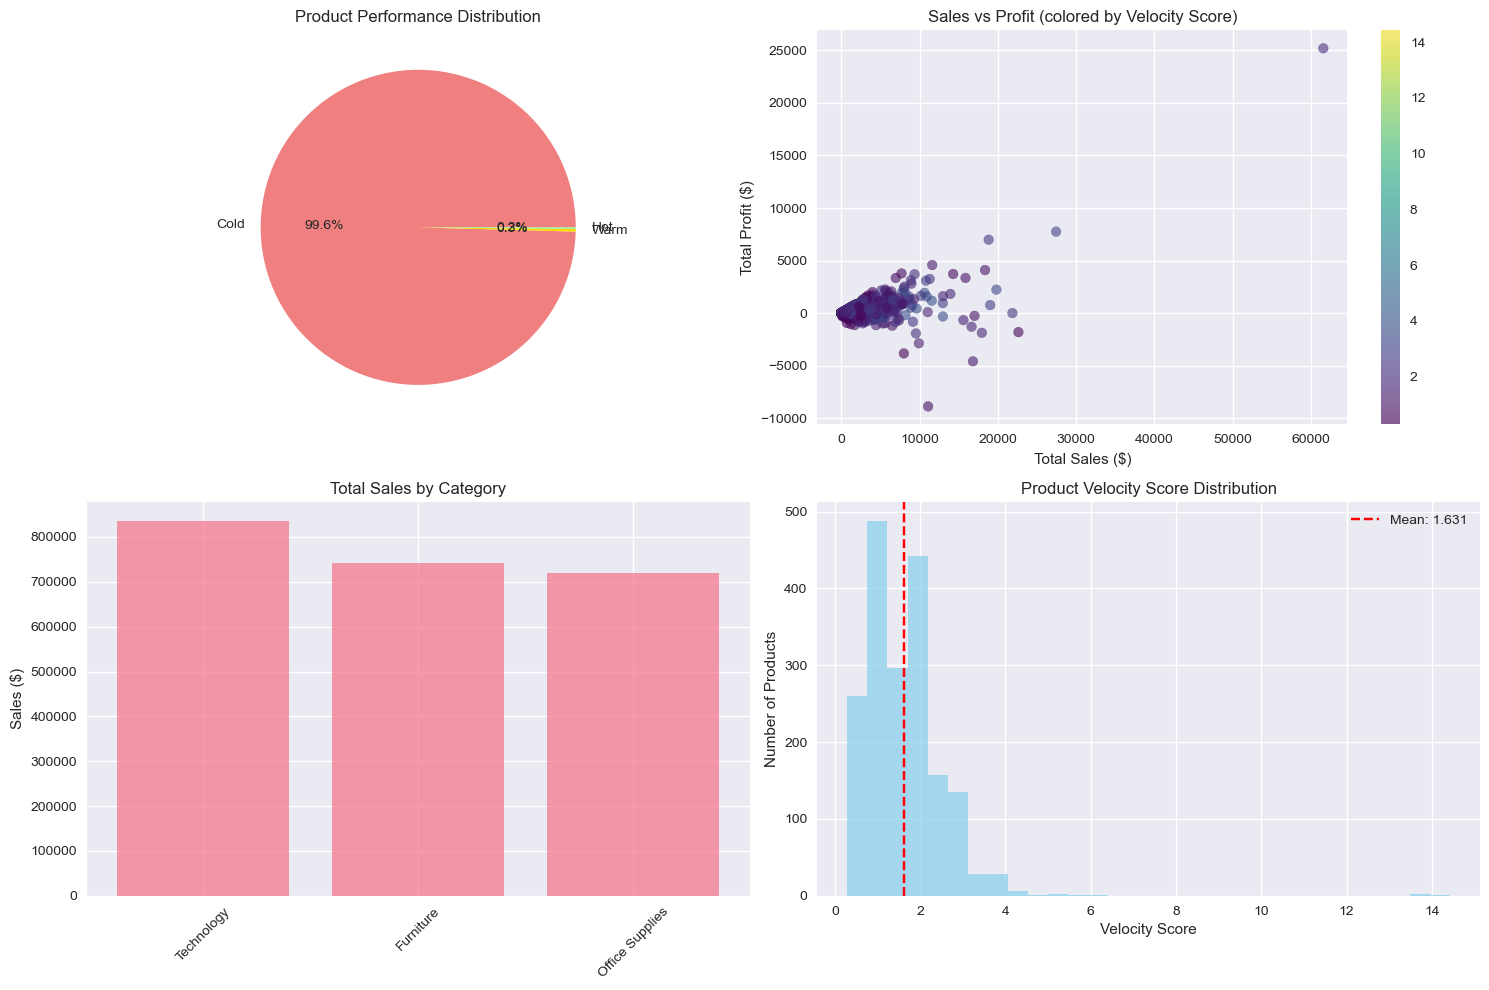

In [24]:
# Visualize hot products analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Product performance distribution
performance_counts = product_metrics['Category_Performance'].value_counts()
axes[0,0].pie(performance_counts.values, labels=performance_counts.index, autopct='%1.1f%%', 
             colors=['lightcoral', 'gold', 'lightgreen'])
axes[0,0].set_title('Product Performance Distribution')

# Sales vs Profit scatter
scatter = axes[0,1].scatter(product_metrics['Total_Sales'], product_metrics['Total_Profit'], 
                           c=product_metrics['Velocity_Score'], cmap='viridis', alpha=0.6)
axes[0,1].set_xlabel('Total Sales ($)')
axes[0,1].set_ylabel('Total Profit ($)')
axes[0,1].set_title('Sales vs Profit (colored by Velocity Score)')
plt.colorbar(scatter, ax=axes[0,1])

# Top categories by performance
category_performance = df.groupby('Category').agg({
    'Sales': 'sum',
    'Profit': 'sum'
}).sort_values('Sales', ascending=False)

axes[1,0].bar(category_performance.index, category_performance['Sales'], alpha=0.7)
axes[1,0].set_title('Total Sales by Category')
axes[1,0].set_ylabel('Sales ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# Velocity score distribution
axes[1,1].hist(product_metrics['Velocity_Score'], bins=30, alpha=0.7, color='skyblue')
axes[1,1].set_xlabel('Velocity Score')
axes[1,1].set_ylabel('Number of Products')
axes[1,1].set_title('Product Velocity Score Distribution')
axes[1,1].axvline(product_metrics['Velocity_Score'].mean(), color='red', linestyle='--', 
                 label=f'Mean: {product_metrics["Velocity_Score"].mean():.3f}')
axes[1,1].legend()

plt.tight_layout()
plt.show()

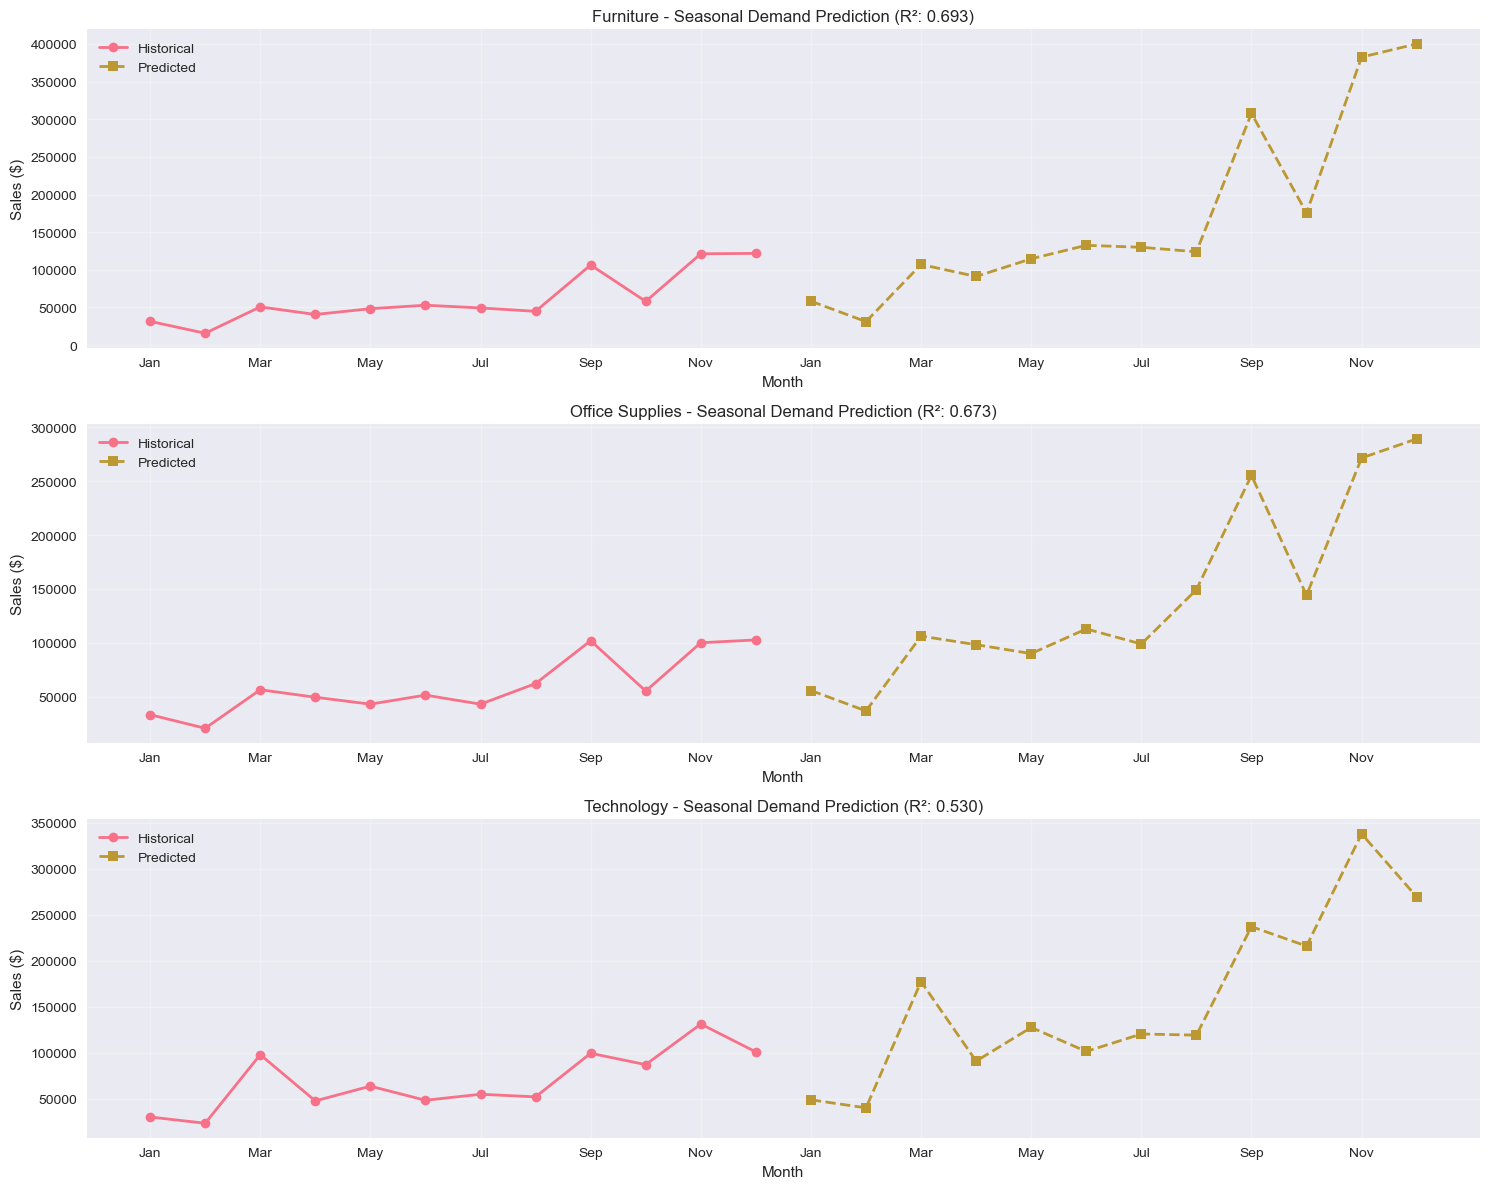

In [25]:
# 14. SEASONAL DEMAND PREDICTION

# Create seasonal demand patterns
seasonal_demand = df.groupby(['Month', 'Category']).agg({
    'Sales': 'sum',
    'Quantity': 'sum'
}).reset_index()

seasonal_pivot = seasonal_demand.pivot(index='Month', columns='Category', values='Sales')

# Predict next year's seasonal demand
from scipy import stats

seasonal_predictions = {}
for category in seasonal_pivot.columns:
    monthly_sales = seasonal_pivot[category].values
    
    # Fit trend line
    months = np.arange(1, 13)
    slope, intercept, r_value, p_value, std_err = stats.linregress(months, monthly_sales)
    
    # Predict next year (months 13-24)
    next_year_months = np.arange(13, 25)
    next_year_base = slope * next_year_months + intercept
    
    # Apply seasonal pattern
    seasonal_pattern = monthly_sales / monthly_sales.mean()
    next_year_seasonal = next_year_base * np.tile(seasonal_pattern, 1)
    
    seasonal_predictions[category] = {
        'Historical': monthly_sales,
        'Predicted': next_year_seasonal,
        'Trend_R2': r_value**2
    }

# Visualize seasonal predictions
fig, axes = plt.subplots(len(seasonal_pivot.columns), 1, figsize=(15, 12))

for i, category in enumerate(seasonal_pivot.columns):
    historical = seasonal_predictions[category]['Historical']
    predicted = seasonal_predictions[category]['Predicted']
    
    # Plot historical data
    axes[i].plot(range(1, 13), historical, marker='o', label='Historical', linewidth=2)
    
    # Plot predictions
    axes[i].plot(range(13, 25), predicted, marker='s', label='Predicted', 
                linestyle='--', linewidth=2)
    
    axes[i].set_title(f'{category} - Seasonal Demand Prediction '
                     f'(R²: {seasonal_predictions[category]["Trend_R2"]:.3f})')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Sales ($)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Add month labels
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    axes[i].set_xticks(range(1, 25, 2))
    axes[i].set_xticklabels([month_labels[(i-1)%12] for i in range(1, 25, 2)])

plt.tight_layout()
plt.show()

In [26]:
# 15. CUSTOMER SEGMENTATION AND BEHAVIOR PREDICTION

# Customer behavior analysis
customer_behavior = df.groupby('Customer ID').agg({
    'Sales': ['sum', 'mean', 'count'],
    'Profit': 'sum',
    'Quantity': 'sum',
    'Discount': 'mean',
    'Order Date': ['min', 'max']
}).round(2)

customer_behavior.columns = ['Total_Spent', 'Avg_Order_Value', 'Order_Frequency', 
                           'Total_Profit_Generated', 'Total_Quantity', 'Avg_Discount',
                           'First_Order', 'Last_Order']

# Calculate customer lifetime and recency
customer_behavior['Days_Active'] = (customer_behavior['Last_Order'] - 
                                   customer_behavior['First_Order']).dt.days + 1
customer_behavior['Days_Since_Last_Order'] = (df['Order Date'].max() - 
                                             customer_behavior['Last_Order']).dt.days

# Customer value segmentation using RFM analysis
from datetime import datetime

# Recency, Frequency, Monetary
reference_date = df['Order Date'].max()
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (reference_date - x.max()).days,  # Recency
    'Row ID': 'count',  # Frequency
    'Sales': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary']

# Create RFM scores (1-5 scale)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])  # Lower recency = higher score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Create customer segments
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Define customer segments based on RFM scores
def categorize_customers(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Champions'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 2:
        return 'Potential Loyalists'
    elif row['R_Score'] >= 4 and row['F_Score'] <= 2:
        return 'New Customers'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
        return 'At Risk'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2 and row['M_Score'] >= 3:
        return "Can't Lose Them"
    else:
        return 'Others'

rfm['Customer_Segment'] = rfm.apply(categorize_customers, axis=1)

print("Customer Segmentation Results:")
segment_summary = rfm.groupby('Customer_Segment').agg({
    'Customer_ID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)
segment_summary.columns = ['Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']
print(segment_summary)

Customer Segmentation Results:
                     Count  Avg_Recency  Avg_Frequency  Avg_Monetary
Customer_Segment                                                    
At Risk                154       246.27          15.56       3759.73
Can't Lose Them         38       323.21           7.87       2788.73
Champions              106        25.48          19.83       5299.80
Loyal Customers        158        50.00          15.97       3832.78
New Customers           38        23.71           5.45        938.26
Others                 152       316.96           5.87        884.00
Potential Loyalists    147        44.39          10.71       1869.73


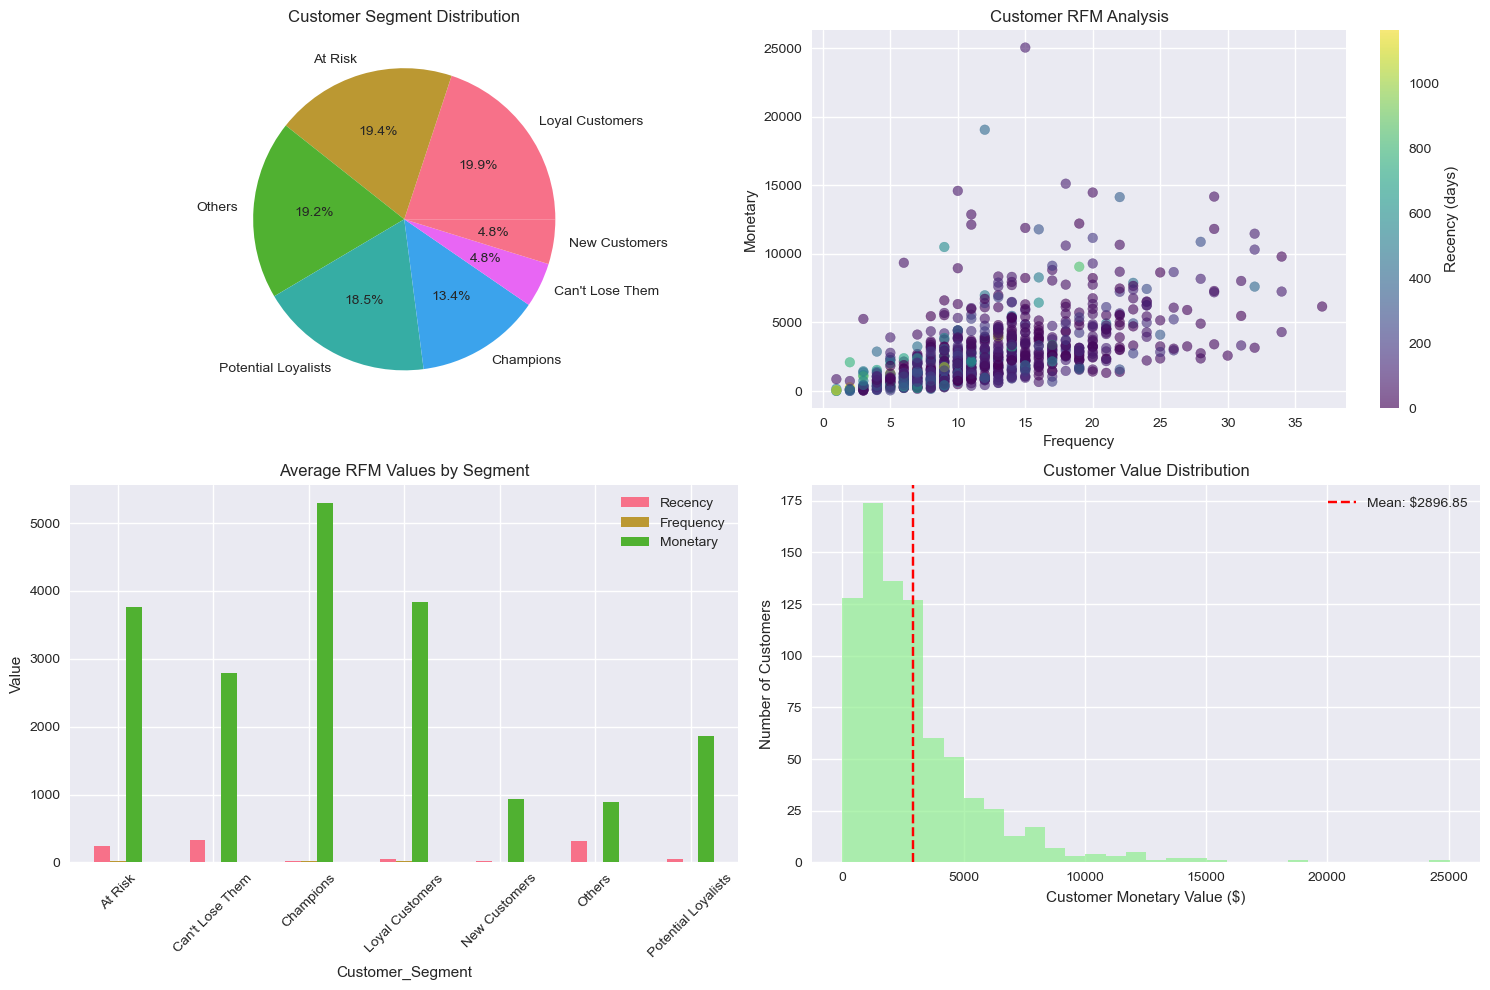

In [27]:
# Visualize customer segmentation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Customer segment distribution
segment_counts = rfm['Customer_Segment'].value_counts()
axes[0,0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('Customer Segment Distribution')

# RFM 3D scatter plot (simplified to 2D)
scatter = axes[0,1].scatter(rfm['Frequency'], rfm['Monetary'], 
                           c=rfm['Recency'], cmap='viridis', alpha=0.6)
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_ylabel('Monetary')
axes[0,1].set_title('Customer RFM Analysis')
plt.colorbar(scatter, ax=axes[0,1], label='Recency (days)')

# Average values by segment
segment_summary_plot = rfm.groupby('Customer_Segment')[['Recency', 'Frequency', 'Monetary']].mean()
segment_summary_plot.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Average RFM Values by Segment')
axes[1,0].set_ylabel('Value')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend()

# Customer value distribution
axes[1,1].hist(rfm['Monetary'], bins=30, alpha=0.7, color='lightgreen')
axes[1,1].set_xlabel('Customer Monetary Value ($)')
axes[1,1].set_ylabel('Number of Customers')
axes[1,1].set_title('Customer Value Distribution')
axes[1,1].axvline(rfm['Monetary'].mean(), color='red', linestyle='--', 
                 label=f'Mean: ${rfm["Monetary"].mean():.2f}')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [28]:
# 16. COMPREHENSIVE BUSINESS INTELLIGENCE DASHBOARD

print("="*80)
print("COMPREHENSIVE BUSINESS INTELLIGENCE SUMMARY")
print("="*80)

# Traffic predictions
next_week_traffic = []
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Predict next 7 days traffic
    last_date = traffic_data.index[-1]
    for i in range(1, 8):
        future_date = last_date + timedelta(days=i)
        features = [
            future_date.dayofweek,  # DayOfWeek
            future_date.month,      # Month
            (future_date.month - 1) // 3 + 1,  # Quarter
            1 if future_date.dayofweek >= 5 else 0,  # IsWeekend
            future_date.day,        # DayOfMonth
            future_date.isocalendar()[1],  # WeekOfYear
            traffic_data['Daily_Traffic'].tail(7).mean(),  # Traffic_MA7
            traffic_data['Daily_Traffic'].tail(30).mean(), # Traffic_MA30
            traffic_data['Daily_Sales'].tail(7).mean()     # Sales_MA7
        ]
        pred_traffic = best_model.predict([features])[0]
        next_week_traffic.append(max(0, pred_traffic))

print(f"\n1. TRAFFIC PREDICTIONS (Next 7 Days):")
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, (day, traffic) in enumerate(zip(days, next_week_traffic)):
    print(f"   {day}: {traffic:.0f} expected orders")

print(f"\n2. HOT PRODUCTS IDENTIFICATION:")
top_hot_products = hot_products.head(5)
for i, (product, row) in enumerate(top_hot_products.iterrows()):
    print(f"   {i+1}. {product[:50]}... (Score: {row['Velocity_Score']:.3f})")

print(f"\n3. CUSTOMER SEGMENT INSIGHTS:")
for segment, data in segment_summary.iterrows():
    print(f"   {segment}: {data['Count']} customers, Avg Value: ${data['Avg_Monetary']:.2f}")

print(f"\n4. SEASONAL DEMAND FORECAST (Next Quarter):")
for category in seasonal_predictions:
    next_quarter_demand = np.sum(seasonal_predictions[category]['Predicted'][:3])
    print(f"   {category}: ${next_quarter_demand:,.2f} predicted sales")

print(f"\n5. RISK ALERTS:")
at_risk_customers = len(rfm[rfm['Customer_Segment'] == 'At Risk'])
cant_lose_customers = len(rfm[rfm['Customer_Segment'] == "Can't Lose Them"])
print(f"   - {at_risk_customers} customers at risk of churning")
print(f"   - {cant_lose_customers} high-value customers need immediate attention")

# Low-performing products
cold_products = len(product_metrics[product_metrics['Category_Performance'] == 'Cold'])
print(f"   - {cold_products} products performing below expectations")

print(f"\n6. STRATEGIC RECOMMENDATIONS:")
print(f"   - Focus marketing on {segment_summary.loc['Champions', 'Count']} Champion customers")
print(f"   - Implement retention campaigns for At Risk customers")
print(f"   - Increase inventory for top {len(hot_products)} hot products")
print(f"   - Review pricing strategy for {cold_products} underperforming products")
print(f"   - Optimize staffing for predicted high-traffic days")

# Model performance summary
print(f"\n7. MODEL PERFORMANCE:")
print(f"   - Traffic Prediction Model: {best_model_name} (R² = {model_results[best_model_name]['R2']:.3f})")
print(f"   - Sales Forecasting: ARIMA (MAPE = {(mae/test_sales.mean())*100:.1f}%)")
print(f"   - Product Classification: {len(product_metrics)} products analyzed")
print(f"   - Customer Segmentation: {len(rfm)} customers segmented")

COMPREHENSIVE BUSINESS INTELLIGENCE SUMMARY

1. TRAFFIC PREDICTIONS (Next 7 Days):
   Monday: 12 expected orders
   Tuesday: 18 expected orders
   Wednesday: 13 expected orders
   Thursday: 5 expected orders
   Friday: 9 expected orders
   Saturday: 11 expected orders
   Sunday: 11 expected orders

2. HOT PRODUCTS IDENTIFICATION:
   1. Staple envelope... (Score: 14.420)
   2. Easy-staple paper... (Score: 13.829)
   3. Staples... (Score: 13.808)
   4. Avery Non-Stick Binders... (Score: 6.002)
   5. Staples in misc. colors... (Score: 5.705)

3. CUSTOMER SEGMENT INSIGHTS:
   At Risk: 154.0 customers, Avg Value: $3759.73
   Can't Lose Them: 38.0 customers, Avg Value: $2788.73
   Champions: 106.0 customers, Avg Value: $5299.80
   Loyal Customers: 158.0 customers, Avg Value: $3832.78
   New Customers: 38.0 customers, Avg Value: $938.26
   Others: 152.0 customers, Avg Value: $884.00
   Potential Loyalists: 147.0 customers, Avg Value: $1869.73

4. SEASONAL DEMAND FORECAST (Next Quarter):
   Fu